### Import Required Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler

# Set the seed
np.random.seed(42)

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

### Create Required Functions and Extract the Image

In [2]:
def plot_compare_images(img1, img2, title1='Image 1', title2='Image 2'):
    """
    Plots a comparison between two images in a subplot.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].imshow(rearrange(img1, 'c h w -> h w c').numpy())
    ax[0].set_title(title1)
    ax[0].axis('off')

    ax[1].imshow(rearrange(img2, 'c h w -> h w c').numpy())
    ax[1].set_title(title2)
    ax[1].axis('off')

    plt.show()

In [3]:
def plot_compare_images_with_missing_data(percentage, img1, img2, img3, title1='Image 1', title2='Image 2', title3='Image 3'):
    """
    Plots a comparison between two images in a subplot.
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))

    ax[0].imshow(rearrange(img1, 'c h w -> h w c').numpy())
    ax[0].set_title(title1)
    ax[0].axis('off')

    ax[1].imshow(rearrange(img2, 'c h w -> h w c').numpy())
    ax[1].set_title(title2)
    ax[1].axis('off')

    ax[2].imshow(rearrange(img3, 'c h w -> h w c').numpy())
    ax[2].set_title(title3)
    ax[2].axis('off')

    plt.suptitle(f"Percentage of missing data: {percentage}%")
    plt.show()

In [4]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    scale: int, the scale factor for the image
    
    return: tuple of torch.Tensor of shape (height * width * scale**2, 2) and torch.Tensor of shape (height * width * scale**2, num_channels)
    """
    
    # Upscale the image
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Reshape the image to (h * w, num_channels)
    Y = torch.tensor(rearrange(img, 'c h w -> (h w) c').float())

    # Move X to GPU if available
    X = X.to(device)
    Y = Y.to(device)
    return X, Y

In [5]:
def RFF_transform(X, n_components, sigma=0.008):
    """
    Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components).
    """

    RFF = RBFSampler(n_components=n_components, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = RFF.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [6]:
class UpscaleModel(nn.Module):
    """
    A simple linear model
    """
    def __init__(self, in_features, out_features):
        super(UpscaleModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    
    def fit(self, X, Y, epochs=1000, lr=0.01):
        """
        X: torch.Tensor of shape (n_samples, n_features)
        Y: torch.Tensor of shape (n_samples, n_channels)
        epochs: int, the number of epochs
        """
        criteria = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        for epoch in range(epochs):
            # Forward pass
            preds = self.linear(X)
            loss = criteria(preds, Y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print the loss
            if (epoch+1) % 1000 == 0:
                print(f'Epoch {epoch+1} Loss: {loss.item()}')

In [7]:
def SNR(image1, image2):
    """
    Compute the Signal-to-Noise Ratio (SNR) between two images.
    """
    # Convert the images to PyTorch tensors
    image1 = torch.tensor(image1, dtype=torch.float32)
    image2 = torch.tensor(image2, dtype=torch.float32)

    # Compute the signal and noise
    signal = image1
    noise = image1 - image2

    # Compute the power of the signal and the noise
    signal_power = torch.sum(signal ** 2)
    noise_power = torch.sum(noise ** 2)

    # Compute the SNR
    snr = 10 * torch.log10(signal_power / noise_power)

    return snr.item()

Original Image Shape: torch.Size([3, 1365, 2048])


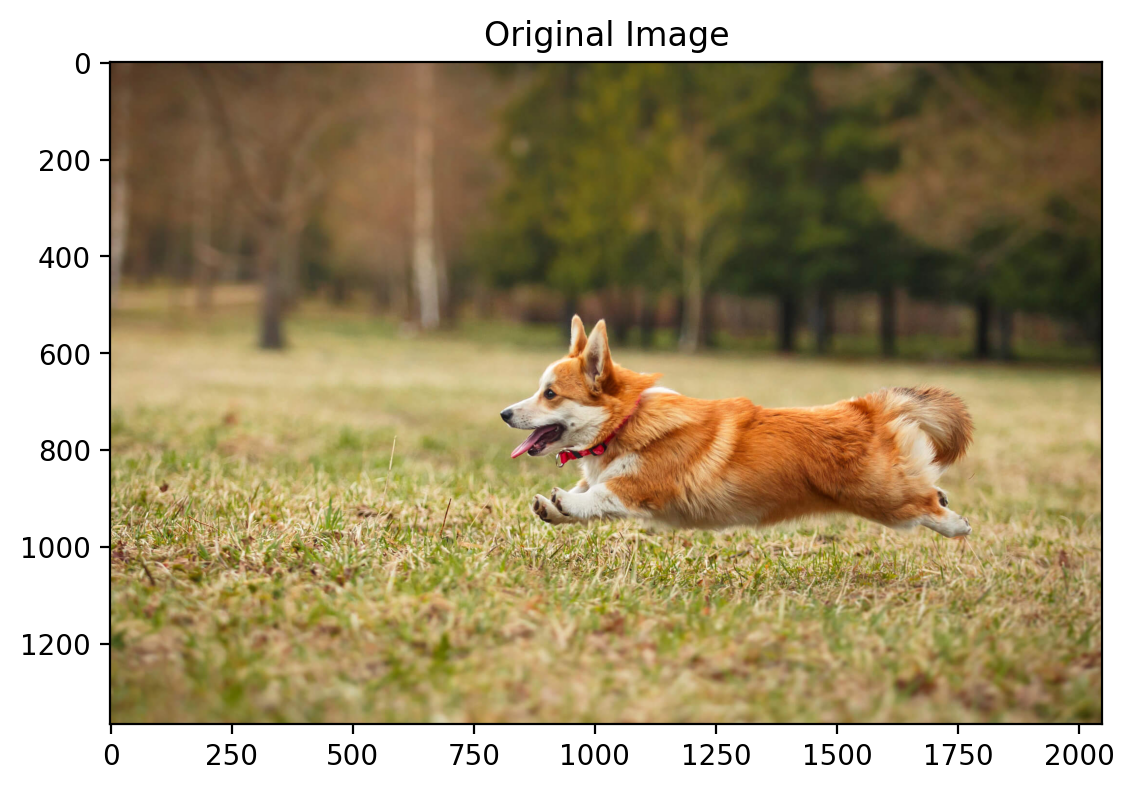

In [8]:
# Set the path to the image
path = 'dog.jpg'

# Load the image
if not os.path.exists(path):
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O Datasets/dog.jpg

# Read in a image from torchvision
img = torchvision.io.read_image(path)
print(f"Original Image Shape: {img.shape}")
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.title('Original Image')
plt.show()

### Upscaling: Qualitative comparison
Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image.

Super Resolution Image Shape: torch.Size([3, 2730, 4096])


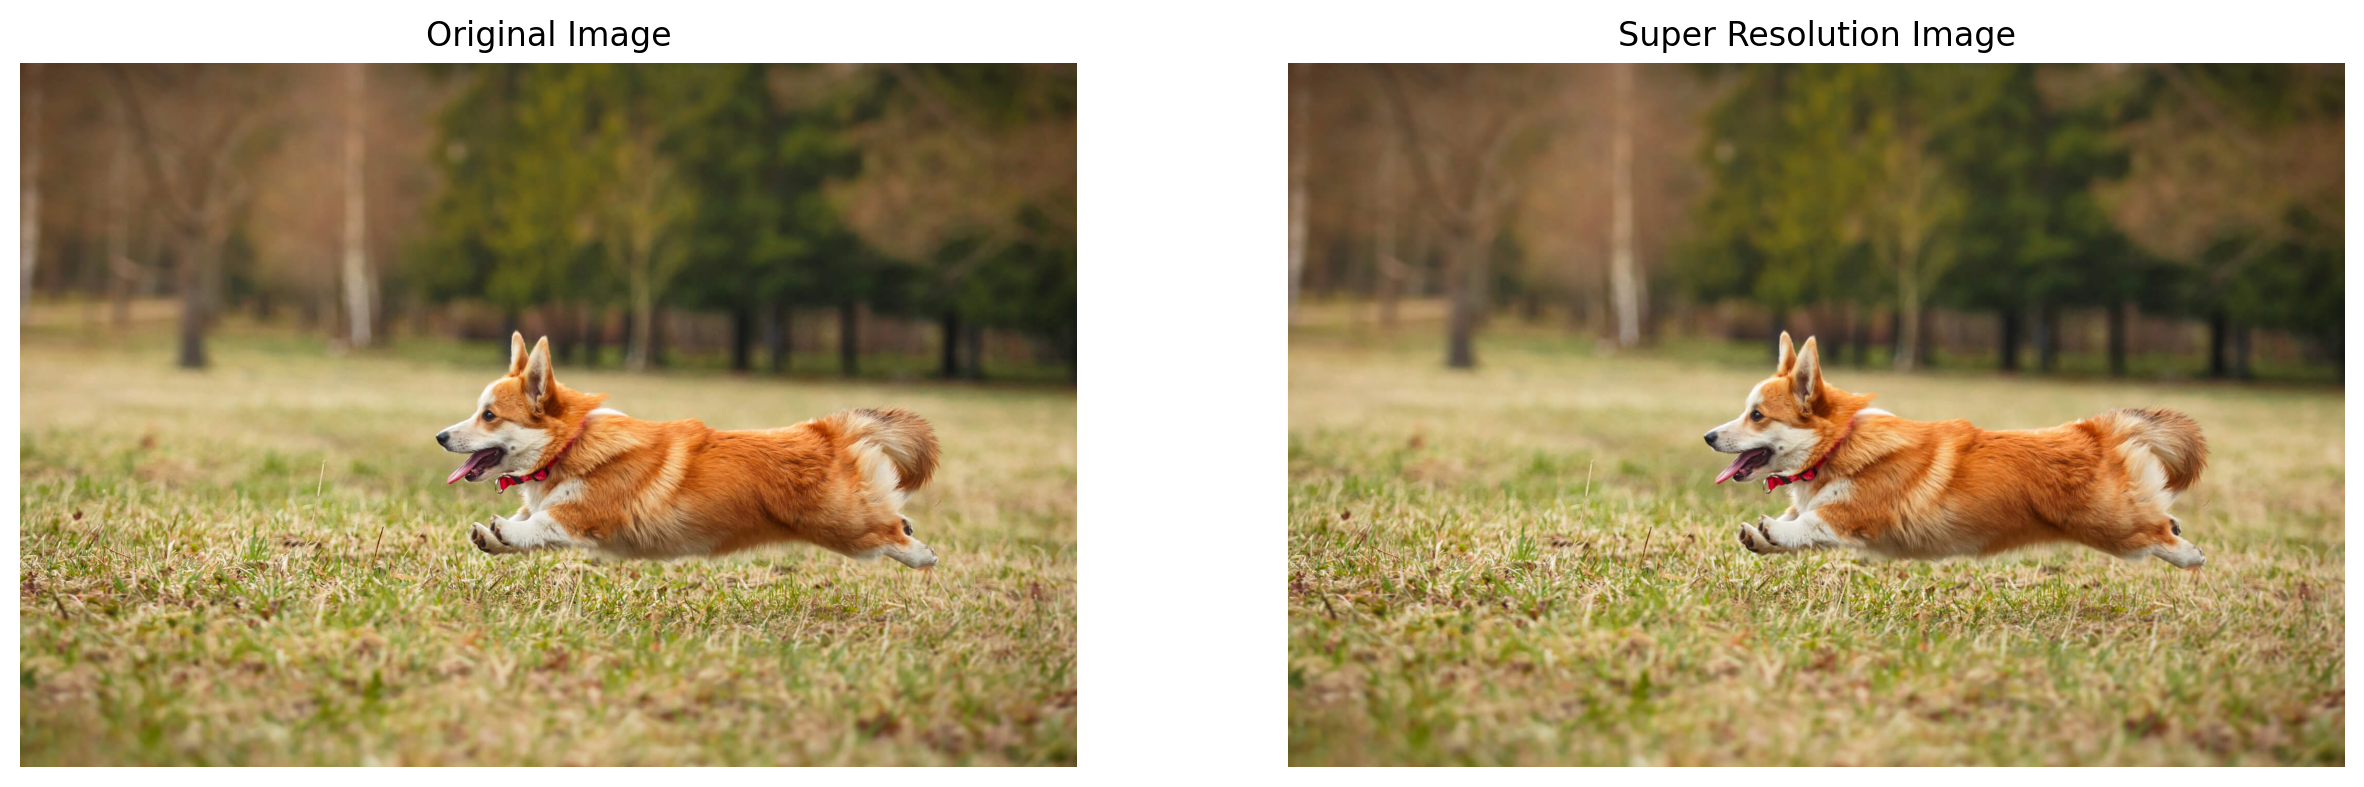

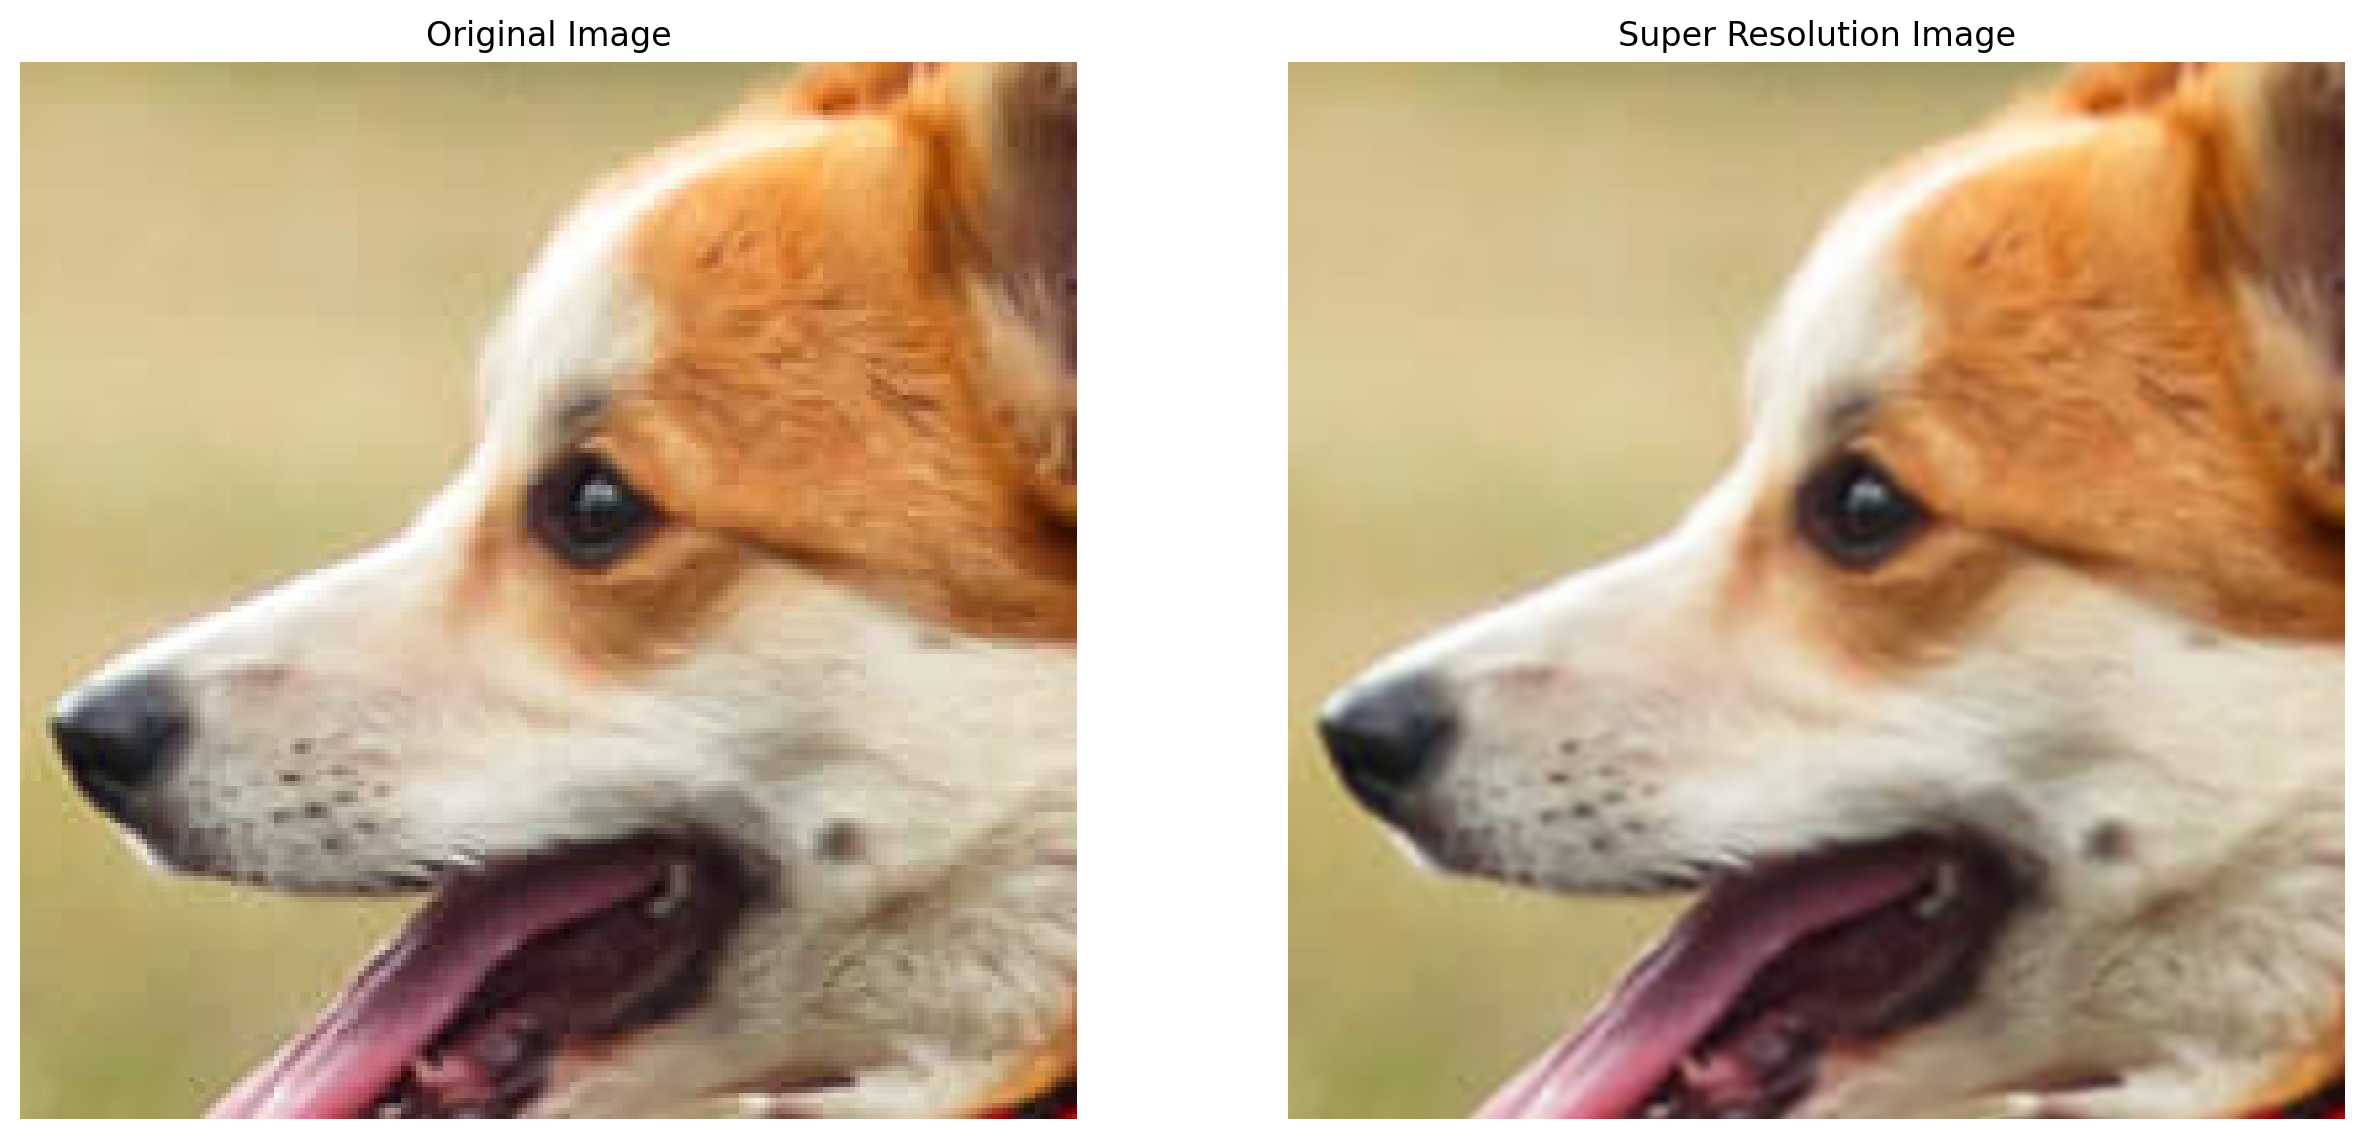

In [9]:
img_super = F.interpolate(img.unsqueeze(0).float(), scale_factor=2, mode='bilinear', align_corners=False).squeeze(0).byte()
print(f"Super Resolution Image Shape: {img_super.shape}")
plot_compare_images(img, img_super, title1='Original Image', title2='Super Resolution Image')

img_cropped = torchvision.transforms.functional.crop(img, 600, 800, 200, 200)
img_super_cropped = torchvision.transforms.functional.crop(img_super, 1200, 1600, 400, 400)
plot_compare_images(img_cropped, img_super_cropped, title1='Original Image', title2='Super Resolution Image')

### Upscaling: Quantitative comparison
Let us now do a quantitative comparison.
- Start with a 400x400 image (ground truth high resolution).
- Resize it to a 200x200 image (input image)
- Use RFF + Linear regression to increase the resolution to 400x400 (predicted high resolution image)
- Compute the following metrics:
  - RMSE on predicted v/s ground truth high resolution image
  - Peak SNR

In [10]:
# Normalize the image
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = torch.tensor(scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape))
img_scaled = img_scaled.to(device)
print(f'Image shape: {img_scaled.shape}')

Image shape: torch.Size([3, 1365, 2048])


Image cropped shape: torch.Size([3, 400, 400])


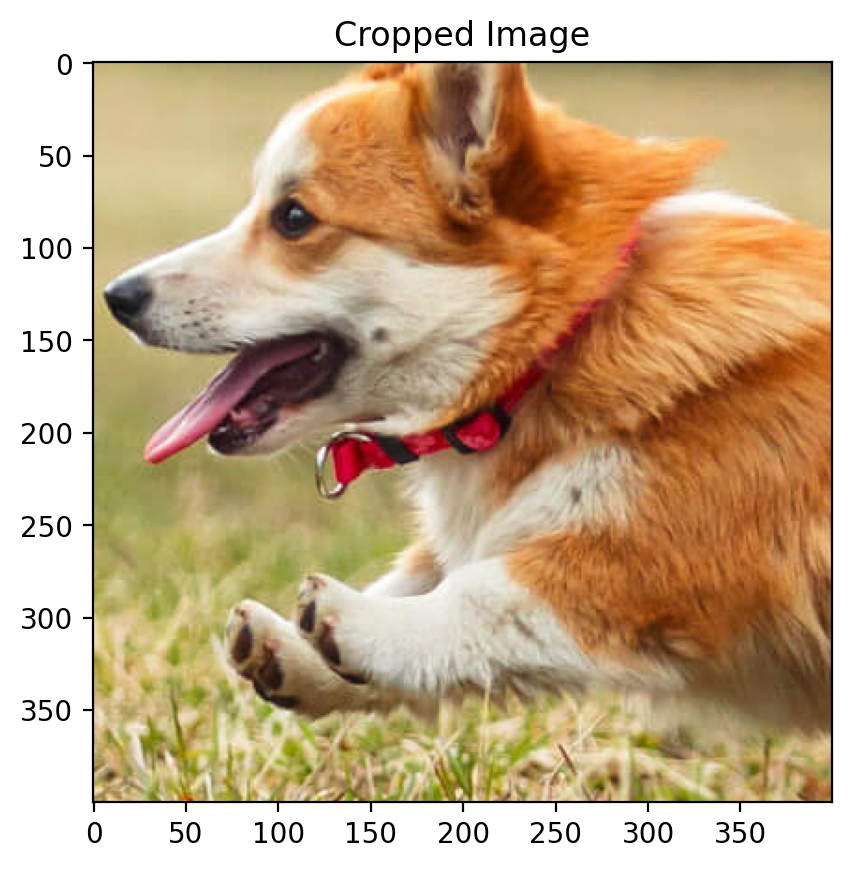

In [11]:
# Crop the image
img_cropped = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
img_cropped = img_cropped.to(device)
print(f'Image cropped shape: {img_cropped.shape}')
plt.imshow(rearrange(img_cropped, 'c h w -> h w c').cpu().numpy())
plt.title('Cropped Image')
plt.show()

Image downscaled shape: torch.Size([3, 200, 200])


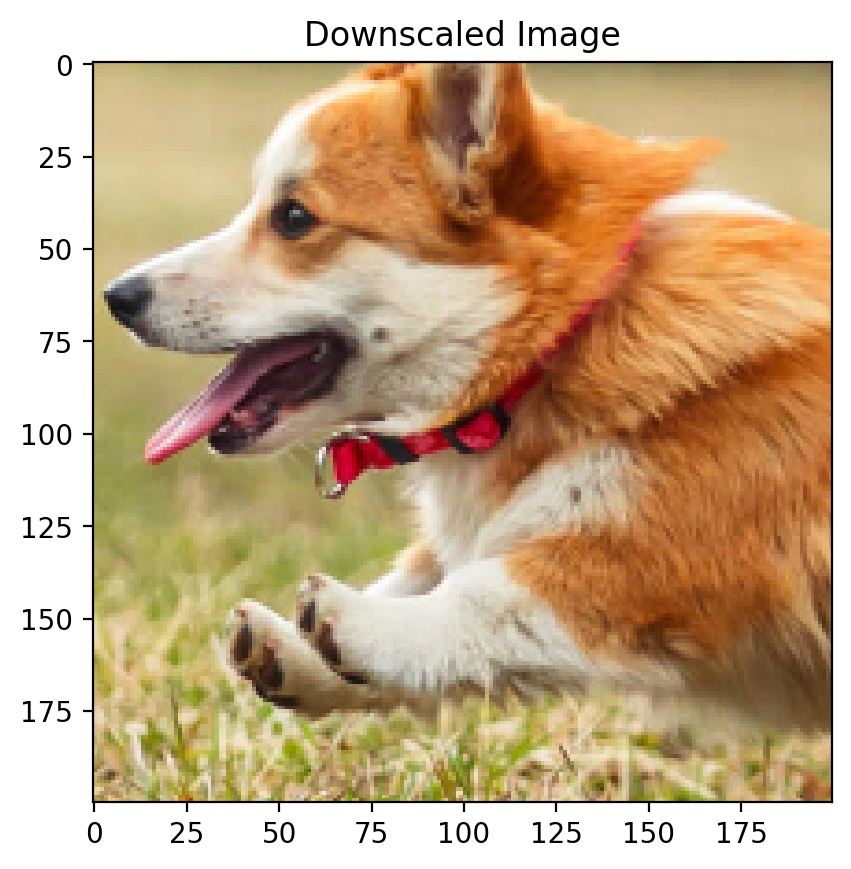

In [12]:
img_downscaled = F.interpolate(img_cropped.unsqueeze(0), size=(200, 200), mode='bilinear', align_corners=False)

# Remove the batch dimension
img_downscaled = img_downscaled.squeeze(0)
print(f'Image downscaled shape: {img_downscaled.shape}')
plt.imshow(img_downscaled.cpu().permute(1, 2, 0))
plt.title('Downscaled Image')
plt.show()

In [13]:
# Create the coordinate map
X, Y = create_coordinate_map(img_cropped, scale=2)
print(f'X shape: {X.shape}, Y shape: {Y.shape}')

# MinMaxScaler from -1 to 1
X_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X.cpu())

# Move the scaled X coordinates to the GPU
X_scaled = torch.tensor(X_scaled).to(device).float()

X shape: torch.Size([160000, 2]), Y shape: torch.Size([160000, 3])


In [14]:
num_features = 22000
X_RFF = RFF_transform(X_scaled, num_features, 0.008)
X_RFF = X_RFF.to(device)
print(f'X_RFF shape: {X_RFF.shape}')

model = UpscaleModel(num_features, 3).to(device)

X_RFF shape: torch.Size([160000, 22000])


In [15]:
model.fit(X_RFF, Y, epochs=20000, lr=0.01)

Epoch 1000 Loss: 0.0007441021734848619
Epoch 2000 Loss: 0.0007018736796453595
Epoch 3000 Loss: 0.0006962622283026576
Epoch 4000 Loss: 0.0006931365933269262
Epoch 5000 Loss: 0.0006911630043759942
Epoch 6000 Loss: 0.0006898432620801032
Epoch 7000 Loss: 0.0006889167707413435
Epoch 8000 Loss: 0.0006881910958327353
Epoch 9000 Loss: 0.0006875974358990788
Epoch 10000 Loss: 0.0006871034274809062
Epoch 11000 Loss: 0.0006866834009997547
Epoch 12000 Loss: 0.0006863023154437542
Epoch 13000 Loss: 0.0006860103458166122
Epoch 14000 Loss: 0.0006857104599475861
Epoch 15000 Loss: 0.0006859282148070633
Epoch 16000 Loss: 0.0006852189544588327
Epoch 17000 Loss: 0.0006849957862868905
Epoch 18000 Loss: 0.0006847703480161726
Epoch 19000 Loss: 0.0006845801253803074
Epoch 20000 Loss: 0.0006844065501354635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


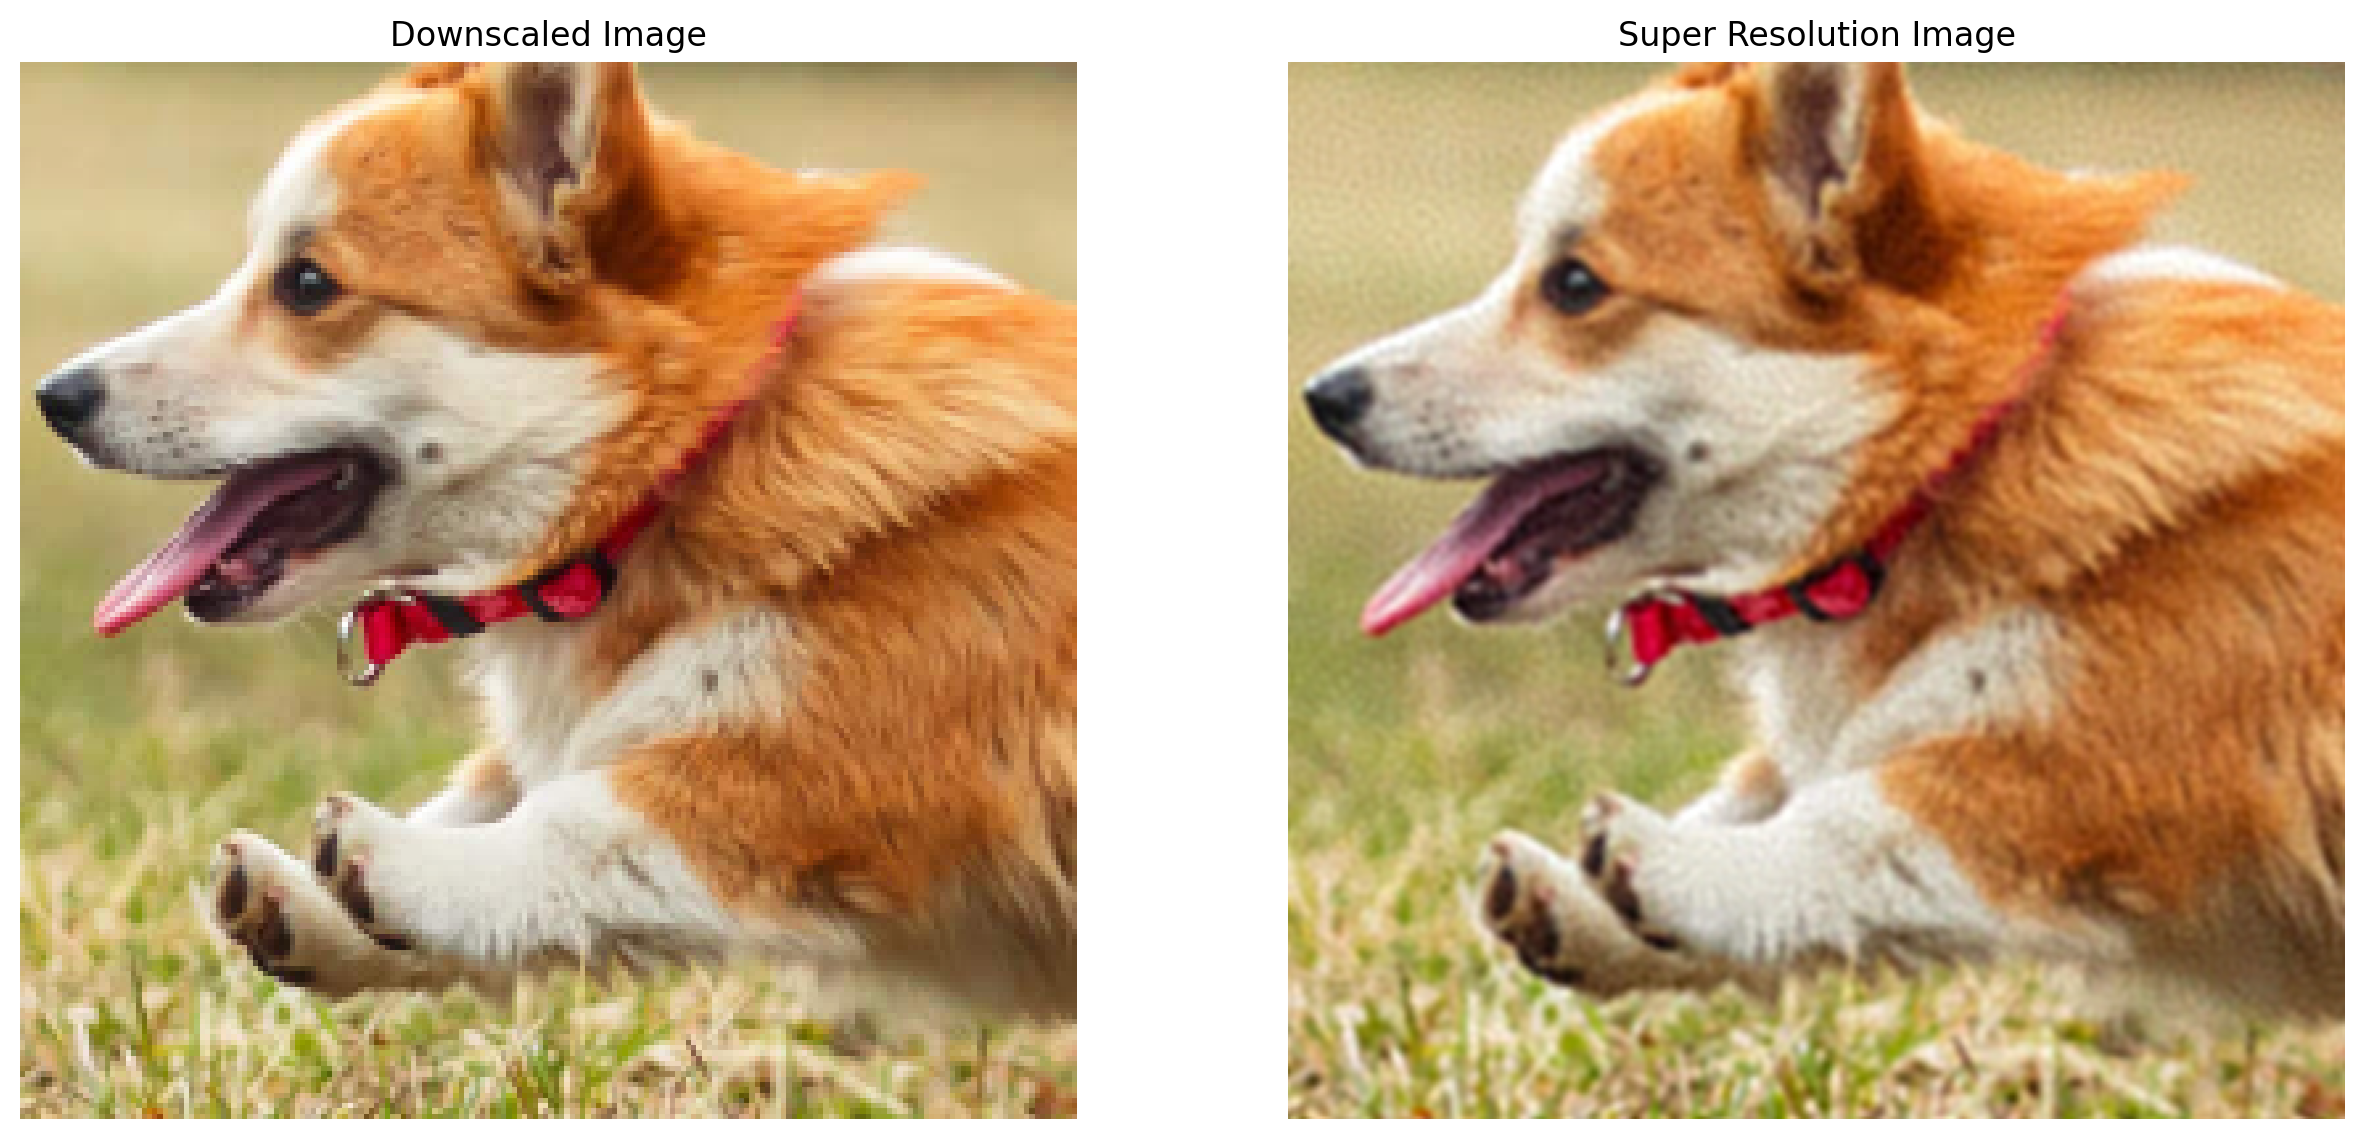

In [16]:
img_super = model(X_RFF).detach()
img_super = rearrange(img_super, '(h w) c -> c h w', h=400)

plot_compare_images(img_downscaled.cpu(), img_super.cpu(), title1='Downscaled Image', title2='Super Resolution Image')

In [17]:
# Compute RMSE
rmse = torch.sqrt(torch.mean((img_super - img_cropped) ** 2))
print('RMSE:', rmse.item())

# Compute the SNR
snr = SNR(img_cropped, img_super)
print('SNR:', snr)

RMSE: 0.0261612258372829
SNR: 27.314144134521484


### Completing Image with Random Missing Data
Apply RFF to complete the image with 10%, 20%, and so on up to 90% of its data missing randomly. Randomly remove portions of the data, train the model on the remaining data, and predict on the entire image. Display the reconstructed images for each missing data percentage and show the metrics calculated above. What do you conclude?.

In [18]:
# Create a mask
mask = torch.rand_like(img_cropped[0])

In [19]:
num_features = 10000
for percentage in range(10, 100, 10):
    # Create a version of the image with data missing
    incomplete_image = img_cropped*(mask > percentage / 100)
    X, _ = create_coordinate_map(incomplete_image)

    # Setting the model
    incomplete_image_RFF = RFF_transform(X, num_features, 0.008)
    incomplete_image_RFF = incomplete_image_RFF.to(device)
    model = UpscaleModel(num_features, 3).to(device)
    model.fit(incomplete_image_RFF, Y, epochs=2000, lr=0.01)

    # Reconstruct the image
    reconstructed_image = model(incomplete_image_RFF).detach()
    reconstructed_image = torch.tensor(rearrange(reconstructed_image, '(h w) c -> c h w', h=400))

    # Display the reconstructed image
    plot_compare_images_with_missing_data(percentage, img_cropped.cpu(), incomplete_image.cpu(), reconstructed_image.cpu(), title1='Original Image', title2='Image with Missing Data', title3='Reconstructed Image')

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.96 GiB (GPU 0; 15.77 GiB total capacity; 13.21 GiB already allocated; 1.58 GiB free; 13.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF